# 4. Ordinal preferences

In this notebook, we are going to see how to implement an election with **ordinal preferences** in our model of voters with embeddings.

An election with **ordinal preferences** corresponds to an election in which each voter gives a **ranking** of the candidates instead of giving a different **score** to each candidate. It has been studied a lot and many rules exists for this model (*Plurality, Borda, k-approval, Condorcet, Instand Runoff, Maximin, Majoritarian judgement, etc.*).

In [37]:
import embedded_voting as ev
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(4242)

## Classic election

Let's **run an election** with **5 candidates** and **100 voters**. We obtain the following profile :

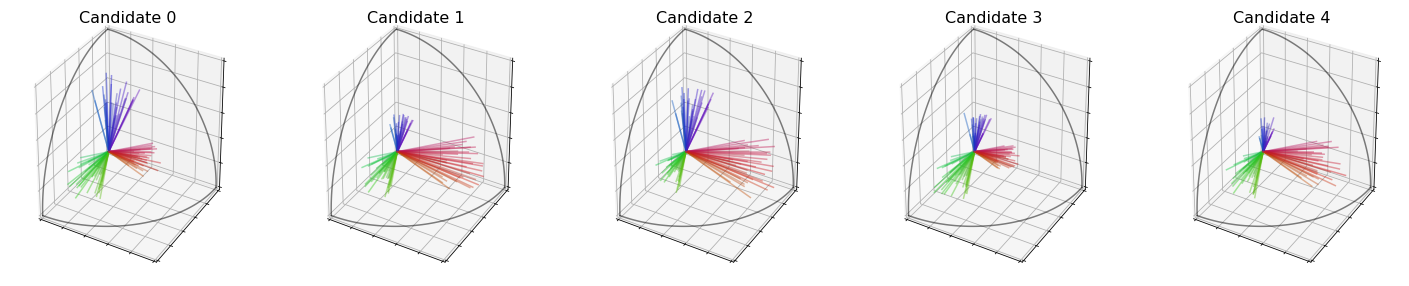

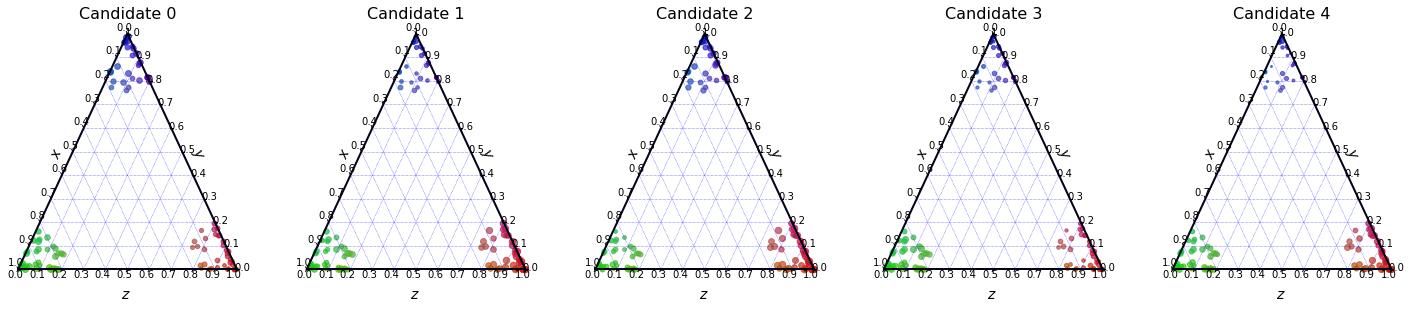

In [38]:
profile = ev.ParametricProfile(5, 3, 100)
profile.set_parameters(polarisation=0.4, coherence=0.7)
profile.plot_candidates("3D")
profile.plot_candidates("ternary")

If we use the rule **SVDNash**, we obtain the following ranking :

$$
c_2 > c_0 > c_1 > c_4 > c_3
$$



In [39]:
election = ev.SVDNash(profile)

We can also print **all the information** about the results of this rule:

In [40]:
print('Scores : ', election.scores_)
print('Ranking : ', election.ranking_)
print('Winner : ', election.winner_)
print('Welfare : ', election.welfare_)

Scores :  [54.931531936897976, 50.62134755524795, 60.969301459853554, 38.26803192506133, 39.8753713527449]
Ranking :  [2, 0, 1, 4, 3]
Winner :  2
Welfare :  [0.734033838340978, 0.5441684929229966, 1.0, 0.0, 0.07080394447632733]


## Positional scoring rules

Now, let's assume that instead of asking a **score vector** to each voter, we ask for a **ranking** of the candidate, and apply some rule with this rankings.

A broad family of rule are **positional scoring rule**. A positional scoring rule is caracterized by a vector $p = (p_1, \ldots, p_m)$ such that each voter $v_i$ gives $p_j$ points to the voters with rank $j$. The winner is the candidate with the maximum total score.

We can adapt this idea by setting the score given by the voter $v_i$ to candidate $c_j$ as $\frac{p_k}{p_n}$ if the candidate $c_j$ is ranked at position $k$ in the ranking of $v_i$.

For instance, if the positional scoring rule is $(2, 1, 1, 1, 0)$, each voter gives a score of $1$ to her favorite candidate, $0$ to her least favorite candidate and $\frac{1}{2}$ to every other candidate:

In [41]:
ordinal_election = ev.PositionalRuleExtension(profile, [2, 1, 1, 1, 0], ev.SVDNash())

If we plot the profile of the differents candidates now, it is very different than before:

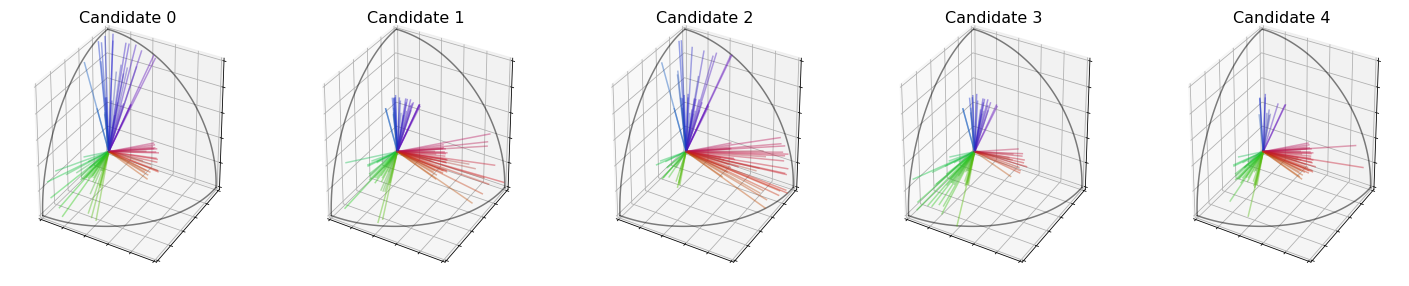

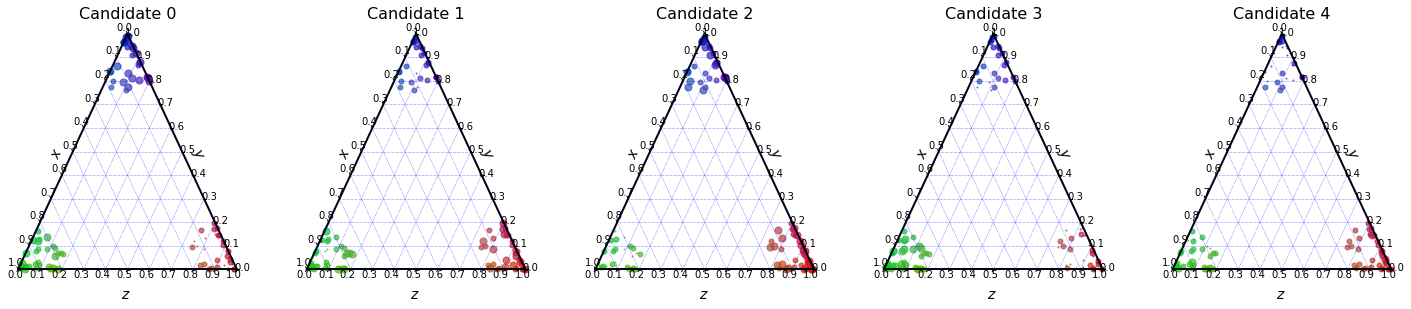

In [42]:
ordinal_election.plot_fake_profile("3D")
ordinal_election.plot_fake_profile("ternary")

The ranking obtained is different too. Indeed, the new ranking is 

$$
c_0 > c_1 > c_2 > c_3 > c_4
$$

and the new winner is $c_0$ instead of $c_2$.

In [43]:
print('Scores : ', ordinal_election.scores_)
print('Ranking : ', ordinal_election.ranking_)
print('Winner : ', ordinal_election.winner_)

Scores :  [58.003136833657514, 56.604139569412496, 54.69097975918287, 34.282566392169485, 32.53282522168502]
Ranking :  [0, 1, 2, 3, 4]
Winner :  0


### Plurality

**Plurality** is the positional scoring rule defined by the scoring vector $(1, 0, \ldots, 0)$. It is equivalent to say that each voter only vote for his favorite candidate. We can see that in that case, almost nobody voted for candidate $c_4$:

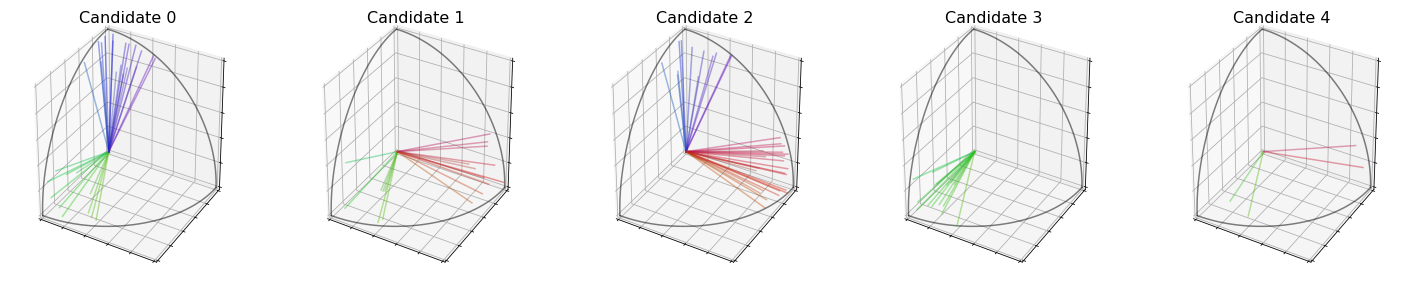

In [44]:
plurality_election = ev.PluralityExtension(profile, ev.SVDNash())
plurality_election.plot_fake_profile("3D")

The ranking obtained is different again, but the winner is still $c_2$ :

$$
c_2 > c_0 > c_1 > c_3 > c_3
$$



In [45]:
print('Scores : ', plurality_election.scores_)
print('Ranking : ', plurality_election.ranking_)
print('Winner : ', plurality_election.winner_)

Scores :  [9.97801310158327, 4.3251327679683484, 11.710542959298193, 0.652686636254298, 0.28073939515444707]
Ranking :  [2, 0, 1, 3, 4]
Winner :  2


### Veto

**Veto** is the opposite of Plurality. In this rule, every voter votes for all candidates **but one**. That is why it looks like every candidate is liked by a lot of voter:

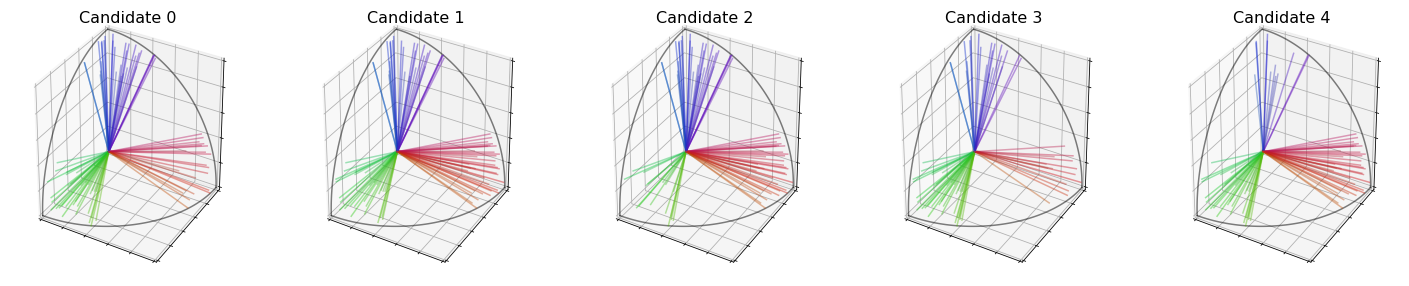

In [46]:
veto_election = ev.VetoExtension(profile, ev.SVDNash())
veto_election.plot_fake_profile("3D")

The ranking is different again, and the new winner is $c_1$

$$
c_1 > c_0 > c_2 > c_4 > c_3
$$



In [47]:
print('Scores : ', veto_election.scores_)
print('Ranking : ', veto_election.ranking_)
print('Winner : ', veto_election.winner_)

Scores :  [109.78992662154377, 125.8050742305231, 100.11753786036667, 80.00385386998099, 86.50269075946835]
Ranking :  [1, 0, 2, 4, 3]
Winner :  1


### k-Approval

**K-approval** is the rule in between Plurality and Veto. Each voter votes for his **k** favorite candidates only. For instance, if $k=3$ :

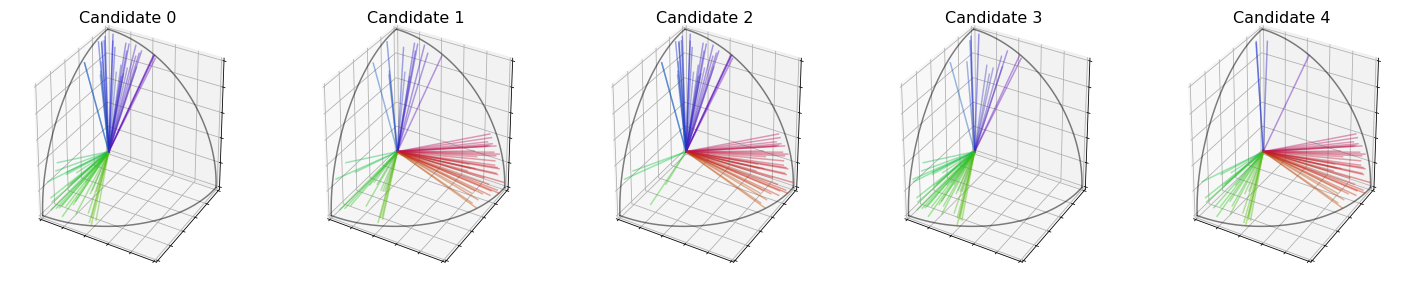

In [48]:
kapp_election = ev.KApprovalExtension(profile, 3, ev.SVDNash())
kapp_election.plot_fake_profile("3D")

The ranking is different again, and the new winner is $c_1$

$$
c_1 > c_2 > c_4 > c_0 > c_3
$$


In [49]:
print('Scores : ', kapp_election.scores_)
print('Ranking : ', kapp_election.ranking_)
print('Winner : ', kapp_election.winner_)

Scores :  [27.45602094307011, 67.39169675235067, 56.792234400966755, 18.06565846922796, 49.39925743150418]
Ranking :  [1, 2, 4, 0, 3]
Winner :  1


### Borda

**Borda** use the scoring vector $(m-1, m-2, \ldots, 1, 0)$ where $m$ is the total number of candidates.

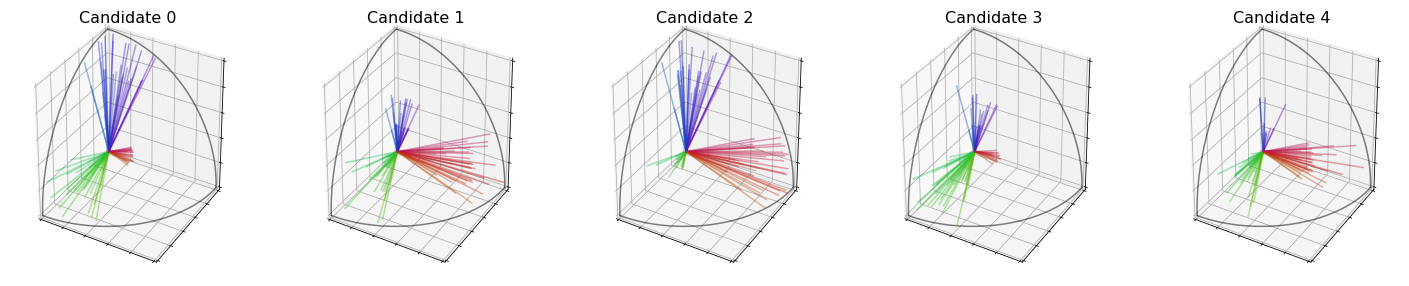

In [53]:
borda_election = ev.BordaExtension(profile, ev.SVDNash())
borda_election.plot_fake_profile("3D")

With this rule, we obtain **the same ranking** than in the original election:

In [54]:
print('Ranking : ', borda_election.ranking_)
print('Winner : ', borda_election.winner_)

Ranking :  [2, 1, 0, 4, 3]
Winner :  2


## Instant Runoff Voting (IRV)

Finally, we implemented **Instant Runoff Voting** which is not a positional scoring rule.

In this voting system, at each step, every voter vote for his favorite candidate, and the candidate with the lowest score **is eliminated**. Consequently, we perform $m-1$ elections before we can find the winner. The ranking obtained is the inverse of the order in which the candidates are eliminated

In [51]:
irv_election = ev.InstantRunoffExtension(profile, ev.SVDNash())

In our case, we obtain the same winner $c_2$ but not the same ranking. The ranking obtained is the same than for **Plurality**.

In [52]:
print('Ranking : ', irv_election.ranking_)
print('Winner : ', irv_election.winner_)

Ranking :  [2, 0, 1, 3, 4]
Winner :  2


## Summary

Here is a little summary of the rankings and winners obtained with the different extensions.

As you can see, the ranking can change a lot if we use an ordinal extension of the voting rule:

| Extension | Ranking   | Winner   |
|-----------|-----------|----------|
| None      |$$c_2 > c_0 > c_1 > c_4 > c_3$$ | $c_2$ |
| $$(2,1,1,1,0)$$   |$$c_0 > c_1 > c_2 > c_3 > c_4$$ | $c_0$ |
| Plurality      |$$c_2 > c_0 > c_1 > c_3 > c_4$$ | $c_2$ |
| Veto      |$$c_1 > c_0 > c_2 > c_4 > c_3$$ | $c_1$ |
| 3-approval      |$$c_1 > c_2 > c_4 > c_0 > c_3$$ | $c_1$ |
| Borda      |$$c_2 > c_0 > c_1 > c_4 > c_3$$ | $c_2$ |
| IRV     |$$c_2 > c_0 > c_1 > c_3 > c_4$$ | $c_2$ |